In [1]:
# scientific libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from skimage import io
from scipy.stats import circvar, circmean, circstd, linregress

# general libraries
import os  
import json
import time
import h5py as h5py
import copy
from functools import partial

# jupyter imports
import ipywidgets as widgets
from IPython.display import clear_output

# local libraries
from analysis import *
from general_utils import *
from hdf_utils import unpack_hdf, Workspace, pack_hdf
from scalebars import *
import deconv

import sac_mode_configs as configs
import experiments as exps
import analysis as ana
from interactive import MotionResponse

In [2]:
%matplotlib widget
plt.rcParams.update({"figure.max_open_warning": 0})
plt.rcParams['svg.fonttype'] = 'none'  # don't save font as paths (assumes font present on machine)

In [3]:
base_path = "/mnt/Data/NEURONoutput/sac_net/"

In [4]:
multiplex_base_paths = {
    "vc": os.path.join(base_path, "multiplex_vc_figs"),
    "spk": os.path.join(base_path, "multiplex_rho_figs"),
}
fig_path = os.path.join(base_path, "multiplex_spk_vc_figs")
fig_subdir = None

fig_subdir, analysis_names = ("rho95_vs_rho95flat", {
    "vc": "rho95_vs_rho95flat_rhoreset",  # note that rng was not fixed, so only avg comparisons are valid
    "spk": "fixed_rho95_vs_rho95flat",    # consider replacing these with fixed runs
})
fig_subdir, analysis_names = ("ctrl_vs_plex", {
    "vc": "ctrl_vs_plex",
    "spk": "ctrl_vs_plex",
})
# fig_subdir, analysis_names = ("testrng", {
#     "vc": "testrng",
#     "spk": "testrng",
# })
# fig_subdir, analysis_names = ("fixedrng", {
#     "vc": "fixedrng",
#     "spk": "fixedrng",
# })
# fig_subdir, analysis_names = ("fixedrng_15n_20tr", {
#     "vc": "fixedrng_15n_20tr",
#     "spk": "fixedrng_15n_20tr",
# })
fig_subdir, analysis_names = ("rho100_30n_20tr", {
    "vc": "rho100_30n_20tr",
    "spk": "rho100_30n_20tr",
})
fig_subdir, analysis_names = ("rho100_ctrl_vs_plex", {
    "vc": "rho100_ctrl_vs_plex",
    "spk": "rho100_ctrl_vs_plex",
})

fig_path = fig_path if fig_subdir is None else os.path.join(fig_path, fig_subdir)
analysis_hdfs = {
    k: h5.File(os.path.join(multiplex_base_paths[k], n, "analysis.h5"), "r")
    for k, n in analysis_names.items()
}
d = {k: Workspace(hdf, read_only=True) for k, hdf in analysis_hdfs.items()}
os.makedirs(fig_path, exist_ok=True)

# use experiments included in vc since they should be a subset of spk (if they differ)
exps = list(d["vc"]["rho_vs_corr_avg"].keys())
rhos = d["vc"]["rhos"][:]

for k, wrk in d.items():
    print("==%s datasets==" % k)
    for name in wrk.keys():
        print(name)
    print("")
    
print("exps:", exps)
print("rhos:", rhos)

==vc datasets==
dir_labels
full_xaxis
gaba_area_dsis
gaba_area_thetas
gaba_peak_dsis
gaba_peak_thetas
residual_corr_full_area
residual_corr_full_midarea
residual_corr_full_net_avg
residual_corr_full_net_std
residual_corr_full_peak_net_avg
residual_corr_full_peak_net_std
residual_corr_valid
residual_corr_valid_net_avg
residual_corr_valid_net_std
residual_corr_valid_trial_avg
residuals_ei_sum_neg_area
residuals_ei_sum_pos_area
residuals_neg_area
residuals_pos_area
rho_vs_corr_avg
rho_vs_corr_std
rhos
sac_deltas
sac_thetas
vc_areas
vc_net_avgs
vc_peaks
vc_trial_avgs
xaxis

==spk datasets==
avg_dir_spikes
circ_180
dir_labels
dir_sort
dirs_180
dirs_180_sorted
dirs_sorted
metrics
net_mets
rho_avg_dsis
rho_avg_spks
rho_dsis
rho_net_avg_dsis
rho_net_avg_spks
rho_spks
rhos
sac_deltas
sac_thetas
std_dir_spikes
xaxis

exps: ['ctrl']
rhos: [0. 1.]


In [5]:
def close_button():
    button = widgets.Button(description="Close Workspace")
    out = widgets.Output()

    def on_clicked(_):
        with out:
            clear_output()
            for wrk in d.values():
                wrk.close()
            print("File closed!")
        
    button.on_click(on_clicked)
    return widgets.VBox([button, out])

close_button()

In [6]:
# list(d["vc"]["residual_corr_full_peak_net_avg"]["ctrl"].keys())
# d["vc"]["rho_vs_corr_avg"]["ctrl"].shape
# d["spk"]["rho_net_avg_dsis"]["ctrl"].shape

dir_labels = d["vc"]["dir_labels"][:]
null_idx = np.argwhere(dir_labels == 180)[0][0]
pref_idx = np.argwhere(dir_labels == 0)[0][0]
pos_ortho_idx = np.argwhere(dir_labels == 90)[0][0]
neg_ortho_idx = np.argwhere(dir_labels == 270)[0][0]


ctrl Pearson R: -0.9999999999999999


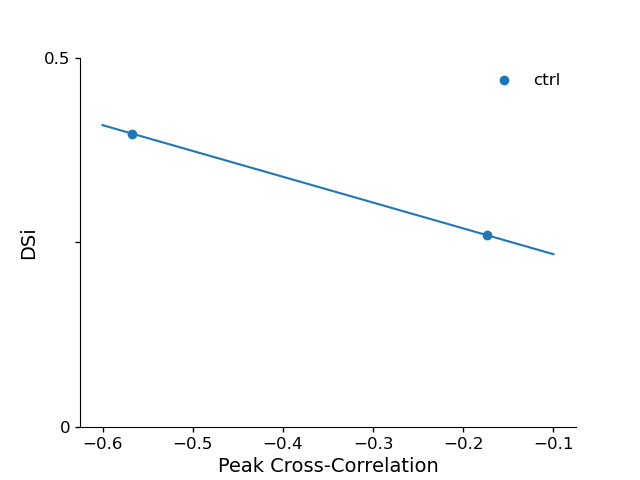

In [7]:
display_exps = exps
display_exps = ["ctrl"]

if len(display_exps) <= 2:
    colours = ["black", "red"]
else:
    colours = ["C0", "C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8"]

avg_corr_vs_dsi_fit_xaxis = np.linspace(-0.6, -0.1, 100)
avg_peak_null_corr_vs_dsi_fig, avg_peak_null_corr_vs_dsi_ax = plt.subplots(1)
for exp in display_exps:
    x = d["vc"]["rho_vs_corr_avg"][exp][null_idx]
    y = np.mean(d["spk"]["rho_net_avg_dsis"][exp], axis=-1)
    avg_peak_null_corr_vs_dsi_ax.scatter(x, y, label=exp)
    fit_coefs = np.polyfit(x, y, 1)
    fit = np.poly1d(fit_coefs)(avg_corr_vs_dsi_fit_xaxis)
    pr = np.corrcoef(x, y)[0, 1]
    print("%s Pearson R: %s" % (exp, str(pr)))
    avg_peak_null_corr_vs_dsi_ax.plot(avg_corr_vs_dsi_fit_xaxis, fit)

avg_peak_null_corr_vs_dsi_ax.set_ylim(0, 0.5)
avg_peak_null_corr_vs_dsi_ax.set_yticks([0, 0.25, 0.5])
avg_peak_null_corr_vs_dsi_ax.set_yticklabels([0, None, 0.5])

avg_peak_null_corr_vs_dsi_ax.set_ylabel("DSi", fontsize=14)
avg_peak_null_corr_vs_dsi_ax.set_xlabel("Peak Cross-Correlation", fontsize=14)
avg_peak_null_corr_vs_dsi_ax.legend(frameon=False, fontsize=12)
clean_axes(avg_peak_null_corr_vs_dsi_ax, ticksize=12)

exps_lbl = "_".join(display_exps)
for ext in [".png", ".svg"]:
    avg_peak_null_corr_vs_dsi_fig.savefig(
        os.path.join(fig_path, "avg_peak_null_corr_vs_dsi_%s%s" % (exps_lbl, ext)),
        bbox_inches="tight"
    )

In [8]:
# peak_null_corr_vs_dsi_fig, peak_null_corr_vs_dsi_ax = plt.subplots(1)
# for exp in exps:
#     peak_null_corr_vs_dsi_ax.scatter(
#         d["vc"]["rho_vs_corr_avg"][exp][null_idx],
#         np.mean(d["spk"]["rho_net_dsis"][exp], axis=-1),
#         label=exp,
#     )

# peak_null_corr_vs_dsi_ax.set_ylim(0, 0.4)
# peak_null_corr_vs_dsi_ax.set_ylabel("DSi")
# peak_null_corr_vs_dsi_ax.set_xlabel("Peak Cross-Correlation")
# peak_null_corr_vs_dsi_ax.legend(frameon=False)
# clean_axes(peak_null_corr_vs_dsi_ax)

shapes (rhos, dirs, nets, trials)
rho_spks: (2, 8, 30, 20)
rho_vs_corr: (2, 8, 30, 20)
ctrl Pearson R: 0.02509985443060235


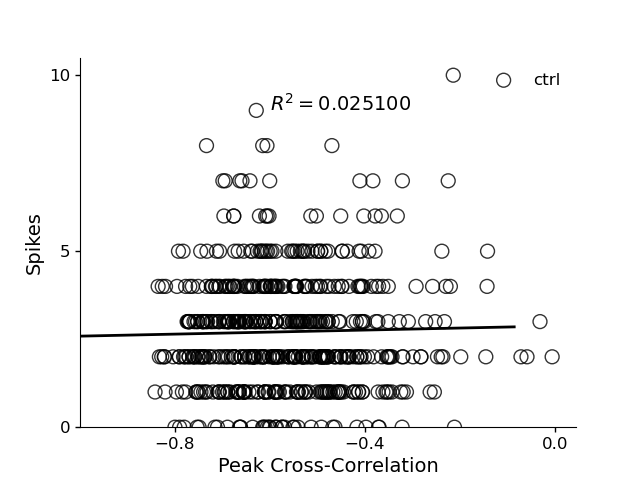

In [28]:
display_exps = exps
display_angle = 180
display_rhos = rhos
display_rhos = [1.0]

display_rho_idxs = np.array([np.argwhere(np.array(rhos) == r)[0][0] for r in display_rhos])
dir_idx = np.argwhere(dir_labels == display_angle)[0][0] 


if len(display_exps) <= 2:
    colours = ["black", "red"]
else:
    colours = ["C0", "C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8"]

_, _, n_spk_nets, n_spk_trials = d["spk"]["rho_spks"]["ctrl"][:].shape
def reshape_resid_metrics(name):
    return {
        exp: np.array(
            [[d["vc"][name][exp][r][n] for n in d["vc"][name][exp][r].keys()] for r in rhos]
        ).transpose(0, 3, 1, 2)
        for exp in exps
    }
    
resid_ei_pos = reshape_resid_metrics("residuals_ei_sum_pos_area")
resid_ei_neg = reshape_resid_metrics("residuals_ei_sum_neg_area")
rho_vs_corr_valid = reshape_resid_metrics("residual_corr_valid")
rho_vs_corr_area = reshape_resid_metrics("residual_corr_full_area") 
rho_vs_corr_midarea = reshape_resid_metrics("residual_corr_full_midarea") 

rho_vs_corr = rho_vs_corr_midarea
rho_vs_corr = rho_vs_corr_valid
min_rvc = np.min([rho_vs_corr[e][display_rho_idxs, dir_idx :n_spk_nets, :n_spk_trials] for e in display_exps])
max_rvc = np.max([rho_vs_corr[e][display_rho_idxs, dir_idx :n_spk_nets, :n_spk_trials] for e in display_exps])

print("shapes (rhos, dirs, nets, trials)")
print("rho_spks:", d["spk"]["rho_spks"]["ctrl"][:].shape)
print("rho_vs_corr:", rho_vs_corr["ctrl"].shape)

spk_rs = {}
spk_locs = {}

corr_vs_spikes_fit_xaxis = np.linspace(min_rvc * 1.2, max_rvc * 1.2, 100)
peak_corr_vs_spks_fig, peak_corr_vs_spks_ax = plt.subplots(1)
for exp, clr in zip(display_exps, colours):
    x = rho_vs_corr[exp][display_rho_idxs, dir_idx, :n_spk_nets, :n_spk_trials].reshape(-1)
    # x = resid_ei_neg[exp][display_rho_idxs, dir_idx, :n_spk_nets, :n_spk_trials].reshape(-1)
    y = d["spk"]["rho_spks"][exp][display_rho_idxs, dir_idx].reshape(-1)
    spk_locs[exp] = [np.mean(x), np.max(y)]
    peak_corr_vs_spks_ax.scatter(x, y, s=100, alpha=0.8, edgecolors=clr, facecolors="none", label=exp)
    fit_coefs = np.polyfit(x, y, 1)
    fit = np.poly1d(fit_coefs)(corr_vs_spikes_fit_xaxis)
    pr = np.corrcoef(x, y)[0, 1]
    slope, intercept, r_value, p_value, std_err = linregress(x, y) 
    spk_rs[exp] = r_value
    print("%s Pearson R: %s" % (exp, str(pr)))
    peak_corr_vs_spks_ax.plot(corr_vs_spikes_fit_xaxis, fit, c=clr, lw=2)
    
    
for exp, clr in zip(display_exps, colours):
    y = spk_locs[exp][1] * 0.9 if exp == top else spk_mids[exp][1] * 1.1
    peak_corr_vs_spks_ax.text(
        -0.6, y, "$R^2 = %f$" % spk_rs[exp], c=clr, fontsize=14)
    
if display_angle == 180: 
    peak_corr_vs_spks_ax.set_ylim(0)
    # peak_corr_vs_spks_ax.set_yticks([0, 4, 8])
    peak_corr_vs_spks_ax.set_yticks([0, 5, 10])
    peak_corr_vs_spks_ax.set_xlim(-1)
    peak_corr_vs_spks_ax.set_xticks([-0.8, -0.4, 0])
else:
    peak_corr_vs_spks_ax.set_ylim(0)
peak_corr_vs_spks_ax.set_ylabel("Spikes", fontsize=14)
peak_corr_vs_spks_ax.set_xlabel("Peak Cross-Correlation", fontsize=14)
peak_corr_vs_spks_ax.legend(frameon=False, fontsize=12)
clean_axes(peak_corr_vs_spks_ax, ticksize=12)

rhos_lbl = "many_rhos" if len(display_rhos) > 4 else "_".join(map(str, display_rhos)).replace(".", "p")
exps_lbl = "_".join(display_exps)
for ext in [".png", ".svg"]:
    peak_corr_vs_spks_fig.savefig(
        os.path.join(
            fig_path, "peak_corr_vs_spks_%s_rhos_%s_dir_%i%s" % (exps_lbl, rhos_lbl, display_angle, ext)),
        bbox_inches="tight"
    )

ctrl Pearson R: 0.0012854341930948342


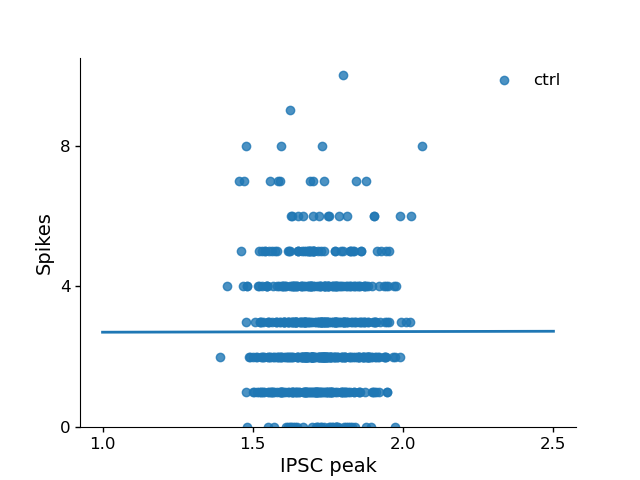

In [10]:
display_exps = exps
display_angle = 180
display_rhos = rhos
display_rhos = [1.0]
area_mode = False

display_rho_idxs = np.array([np.argwhere(np.array(rhos) == r)[0][0] for r in display_rhos])
gaba_metric = "area" if area_mode else "peak"
dir_idx = np.argwhere(dir_labels == display_angle)[0][0] 
gaba_vs_spikes_fit_xaxis = np.linspace(2500, 4500, 100) if area_mode else np.linspace(1, 2.5, 100)
gaba_vs_spks_fig, gaba_vs_spks_ax = plt.subplots(1)
for exp in display_exps:
    x = np.stack(
        [d["vc"]["vc_%ss" % gaba_metric][exp][r]["GABA"] for r in rhos], axis=0
    )[display_rho_idxs, :n_spk_nets, :n_spk_trials, dir_idx].reshape(-1)
    y = d["spk"]["rho_spks"][exp][display_rho_idxs, dir_idx].reshape(-1)
    gaba_vs_spks_ax.scatter(x, y, alpha=0.8, label=exp)
    fit_coefs = np.polyfit(x, y, 1)
    fit = np.poly1d(fit_coefs)(gaba_vs_spikes_fit_xaxis)
    pr = np.corrcoef(x, y)[0, 1]
    print("%s Pearson R: %s" % (exp, str(pr)))
    gaba_vs_spks_ax.plot(gaba_vs_spikes_fit_xaxis, fit, lw=2)
    
if display_angle == 180: 
    gaba_vs_spks_ax.set_ylim(0)
    gaba_vs_spks_ax.set_yticks([0, 4, 8])
    gaba_vs_spks_ax.set_xticks([1, 1.5, 2.0, 2.5])
else:
    gaba_vs_spks_ax.set_ylim(0)
gaba_vs_spks_ax.set_ylabel("Spikes", fontsize=14)
gaba_vs_spks_ax.set_xlabel("IPSC %s" % gaba_metric, fontsize=14)
gaba_vs_spks_ax.legend(frameon=False, fontsize=12)
clean_axes(gaba_vs_spks_ax, ticksize=12)

exps_lbl = "_".join(display_exps)
rhos_lbl = "many_rhos" if len(display_rhos) > 4 else "_".join(map(str, display_rhos)).replace(".", "p")
for ext in [".png", ".svg"]:
    gaba_vs_spks_fig.savefig(
        os.path.join(fig_path, "gaba_%s_vs_spks_%s_rhos_%s_dir_%i%s" % (
            exps_lbl, rhos_lbl, gaba_metric, display_angle, ext)),
        bbox_inches="tight"
    )

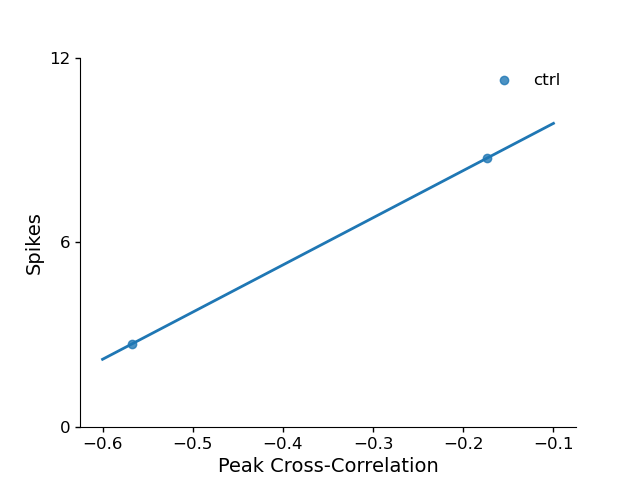

In [11]:
display_exps = exps
display_exps = ["ctrl"]
display_angle = 180

dir_idx = np.argwhere(dir_labels == display_angle)[0][0] 
avg_corr_vs_spikes_fit_xaxis = np.linspace(-0.6, -0.1, 100)
avg_peak_corr_vs_spks_fig, avg_peak_corr_vs_spks_ax = plt.subplots(1)
for exp in display_exps:
    x = d["vc"]["rho_vs_corr_avg"][exp][dir_idx]
    y = d["spk"]["rho_net_avg_spks"][exp][:, dir_idx].mean(axis=-1)
    avg_peak_corr_vs_spks_ax.scatter(x, y, alpha=0.8, label=exp)
    fit_coefs = np.polyfit(x, y, 1)
    fit = np.poly1d(fit_coefs)(avg_corr_vs_spikes_fit_xaxis)
    avg_peak_corr_vs_spks_ax.plot(avg_corr_vs_spikes_fit_xaxis, fit, lw=2)
    
if display_angle == 180:
    avg_peak_corr_vs_spks_ax.set_ylim(0)
    avg_peak_corr_vs_spks_ax.set_yticks([0, 6, 12])
else:
    avg_peak_corr_vs_spks_ax.set_ylim(0)
avg_peak_corr_vs_spks_ax.set_ylabel("Spikes", fontsize=14)
avg_peak_corr_vs_spks_ax.set_xlabel("Peak Cross-Correlation", fontsize=14)
avg_peak_corr_vs_spks_ax.legend(frameon=False, fontsize=12)
clean_axes(avg_peak_corr_vs_spks_ax, ticksize=12)

exps_lbl = "_".join(display_exps)
for ext in [".png", ".svg"]:
    avg_peak_corr_vs_spks_fig.savefig(
        os.path.join(fig_path, "avg_peak_corr_%s_dir_%i%s" % (exps_lbl, display_angle, ext)),
        bbox_inches="tight"
    )

ctrl Pearson R: -0.9999999999999999


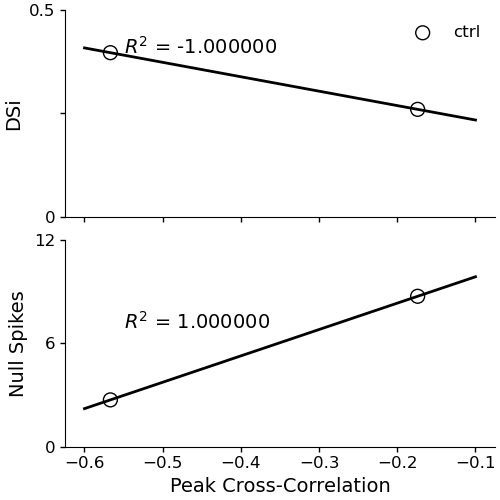

In [12]:
display_exps = exps
display_exps = ["ctrl"]

if len(display_exps) <= 2:
    colours = ["black", "red"]
else:
    colours = ["C%i" % i for i in range(15)]

dsi_rs = {}
dsi_mids = {}
spk_rs = {}
spk_mids = {}

dir_idx = np.argwhere(dir_labels == display_angle)[0][0] 
avg_peak_null_corr_vs_dsi_and_spks_fig, avg_peak_null_corr_vs_dsi_and_spks_ax = plt.subplots(
    2, sharex=True, figsize=(5, 5))
for exp, clr in zip(display_exps, colours):
    # DSI
    x = d["vc"]["rho_vs_corr_avg"][exp][null_idx]
    y = np.mean(d["spk"]["rho_net_avg_dsis"][exp], axis=-1)
    dsi_mids[exp] = [np.mean(x), np.mean(y)]
    avg_peak_null_corr_vs_dsi_and_spks_ax[0].scatter(
        x, y, alpha=1, s=100, facecolors="none", edgecolors=clr, label=exp)
    fit_coefs = np.polyfit(x, y, 1)
    fit = np.poly1d(fit_coefs)(avg_corr_vs_dsi_fit_xaxis)
    pr = np.corrcoef(x, y)[0, 1]
    print("%s Pearson R: %s" % (exp, str(pr)))
    avg_peak_null_corr_vs_dsi_and_spks_ax[0].plot(avg_corr_vs_dsi_fit_xaxis, fit, c=clr, lw=2)
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    dsi_rs[exp] = r_value
    
    # spikes
    x = d["vc"]["rho_vs_corr_avg"][exp][null_idx]
    y = d["spk"]["rho_net_avg_spks"][exp][:, null_idx].mean(axis=-1)
    spk_mids[exp] = [np.mean(x), np.mean(y)]
    avg_peak_null_corr_vs_dsi_and_spks_ax[1].scatter(
        x, y, alpha=1, s=100, facecolors="none", edgecolors=clr, label=exp)
    fit_coefs = np.polyfit(x, y, 1)
    fit = np.poly1d(fit_coefs)(avg_corr_vs_spikes_fit_xaxis)
    avg_peak_null_corr_vs_dsi_and_spks_ax[1].plot(avg_corr_vs_spikes_fit_xaxis, fit, c=clr, lw=2)
    slope, intercept, r_value, p_value, std_err = linregress(x, y) 
    spk_rs[exp] = r_value
    
if len(display_exps) > 1:
    top = display_exps[0] if (
        dsi_mids[display_exps[0]][1] > dsi_mids[display_exps[1]][1]) else display_exps[1]
else:
    top = display_exps[0]
                                                                  
for exp, clr in zip(display_exps, colours):
    y = dsi_mids[exp][1] * 1.2 if exp == top else dsi_mids[exp][1] * 0.8
    avg_peak_null_corr_vs_dsi_and_spks_ax[0].text(
        -0.55, y, "$R^2$ = %f" % dsi_rs[exp], c=clr, fontsize=14)
    y = spk_mids[exp][1] * 1.2 if exp == top else spk_mids[exp][1] * 0.8
    avg_peak_null_corr_vs_dsi_and_spks_ax[1].text(
        -0.55, y, "$R^2$ = %f" % spk_rs[exp], c=clr, fontsize=14)
    
avg_peak_null_corr_vs_dsi_and_spks_ax[0].set_ylim(0, 0.5)
avg_peak_null_corr_vs_dsi_and_spks_ax[0].set_yticks([0, 0.25, 0.5])
avg_peak_null_corr_vs_dsi_and_spks_ax[0].set_yticklabels([0, None, 0.5])
avg_peak_null_corr_vs_dsi_and_spks_ax[0].set_ylabel("DSi", fontsize=14)
    
avg_peak_null_corr_vs_dsi_and_spks_ax[1].set_ylim(0)
avg_peak_null_corr_vs_dsi_and_spks_ax[1].set_yticks([0, 6, 12])
    
avg_peak_null_corr_vs_dsi_and_spks_ax[1].set_ylabel("Null Spikes", fontsize=14)
avg_peak_null_corr_vs_dsi_and_spks_ax[1].set_xlabel("Peak Cross-Correlation", fontsize=14)

avg_peak_null_corr_vs_dsi_and_spks_ax[0].legend(frameon=False, fontsize=12)
clean_axes(avg_peak_null_corr_vs_dsi_and_spks_ax, ticksize=12)
avg_peak_null_corr_vs_dsi_and_spks_fig.set_layout_engine("compressed")

exps_lbl = "_".join(display_exps)
for ext in [".png", ".svg"]:
    avg_peak_null_corr_vs_dsi_and_spks_fig.savefig(
        os.path.join(fig_path, "avg_peak_corr_dsi_and_null_spks%s%s" % (exps_lbl, ext)),
        bbox_inches="tight"
    )

In [13]:
close_button()